In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_parquet('daily_weather.parquet')

In [3]:
stockholm_data = df[df['city_name'] == 'Stockholm']

stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])

# Extraire l'année à partir de la colonne 'date'
stockholm_data['year'] = stockholm_data['date'].dt.year

C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\1401192492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])
C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\1401192492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['year'] = stockholm_data['date'].dt.year


# Snow per year #

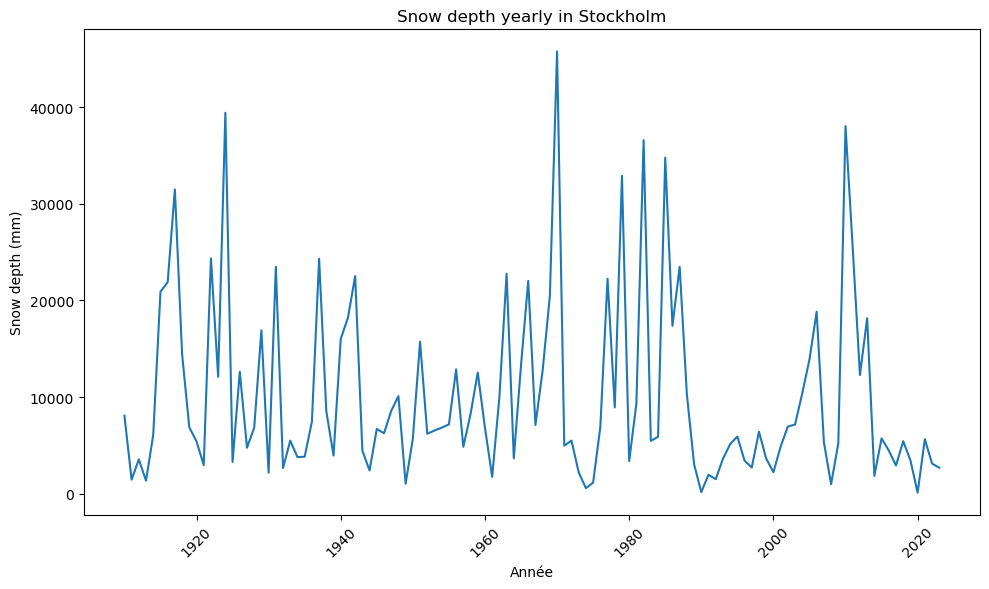

In [19]:
snow_per_year = stockholm_data.groupby('year')['snow_depth_mm'].sum()[50:]
plt.figure(figsize=(10,6))
plt.plot(snow_per_year.index, snow_per_year.values)
plt.title(f"Snow depth yearly in {'Stockholm'}")
plt.xlabel("Année")
plt.ylabel("Snow depth (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
filtered_df = stockholm_data[['date', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                              'precipitation_mm', 'avg_wind_dir_deg', 
                              'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                              'snow_depth_mm']]
# Extraire le mois et le jour à partir de la colonne 'date'
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['year'] = filtered_df['date'].dt.year
# Réorganiser l'ordre des colonnes pour avoir le mois et le jour en premier
filtered_df = filtered_df[['date','year','month', 'day', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                           'precipitation_mm', 'avg_wind_dir_deg', 
                           'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                           'snow_depth_mm']]
filtered_df=filtered_df.dropna()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\3402201212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['date'].dt.month
C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\3402201212.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['day'] = filtered_df['date'].dt.day
C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\3402201212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [21]:
def create_dataset(window_size):
    filtered_df_clean = filtered_df.sort_values(by='date')
    

    # Créer des décalages pour les 10 derniers jours (lags)
    for i in range(1, window_size+1):
        filtered_df_clean[f'min_temp_c_lag_{i}'] = filtered_df_clean['min_temp_c'].shift(i)
        filtered_df_clean[f'max_temp_c_lag_{i}'] = filtered_df_clean['max_temp_c'].shift(i)
        filtered_df_clean[f'precipitation_mm_lag_{i}'] = filtered_df_clean['precipitation_mm'].shift(i)
        filtered_df_clean[f'avg_wind_speed_kmh_lag_{i}'] = filtered_df_clean['avg_wind_speed_kmh'].shift(i)
        filtered_df_clean[f'avg_sea_level_pres_hpa_lag_{i}'] = filtered_df_clean['avg_sea_level_pres_hpa'].shift(i)
        filtered_df_clean[f'snow_depth_mm_lag_{i}'] = filtered_df_clean['snow_depth_mm'].shift(i)


    filtered_df_clean = filtered_df_clean.dropna()
    return(filtered_df_clean)

filtered_df_clean=create_dataset(window_size=10)

In [22]:
def create_train_test(filtered_df_clean,scale=True):
    train_data = filtered_df_clean[filtered_df_clean['year'].isin([2021, 2022])]
    test_data = filtered_df_clean[filtered_df_clean['year'] == 2023]
    X_train = train_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_train = train_data['snow_depth_mm']

    X_test = test_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_test = test_data['snow_depth_mm']
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    else:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    return(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data)

In [23]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressor, self).__init__()
        self.hidden1 = nn.Linear(input_size, 256)
        self.hidden2 = nn.Linear(256, 512)
        self.hidden3 = nn.Linear(512, 128)
        self.hidden4 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

In [24]:
X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data=create_train_test(filtered_df_clean,scale=False)

In [39]:
Best_losses=[]
for k in range(1):
    input_size = X_train_tensor.shape[1]  # Nombre de features
    model = MLPRegressor(input_size)

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner le modèle
    epochs = 200
    training_loss = []
    testing_loss = []

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Enregistrer la perte d'entraînement
        training_loss.append(loss.item())
        
        # Calculer la perte sur les données de test
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            testing_loss.append(test_loss.item())
    
    Best_losses.append(np.min(testing_loss))

Best_losses=np.array(Best_losses)
print("average loss",np.mean(Best_losses),"std",np.std(Best_losses))

average loss 378.5824279785156 std 0.0


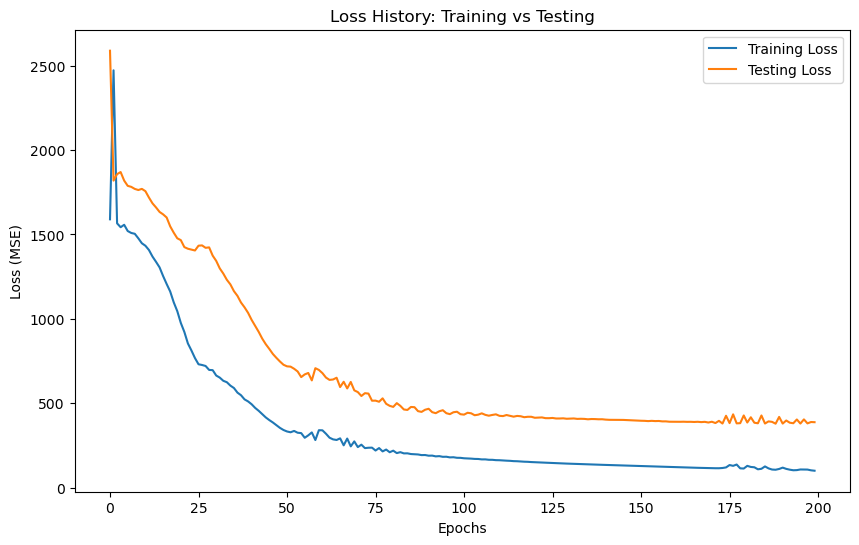

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.title('Loss History: Training vs Testing')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_32376\1755146442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = predictions


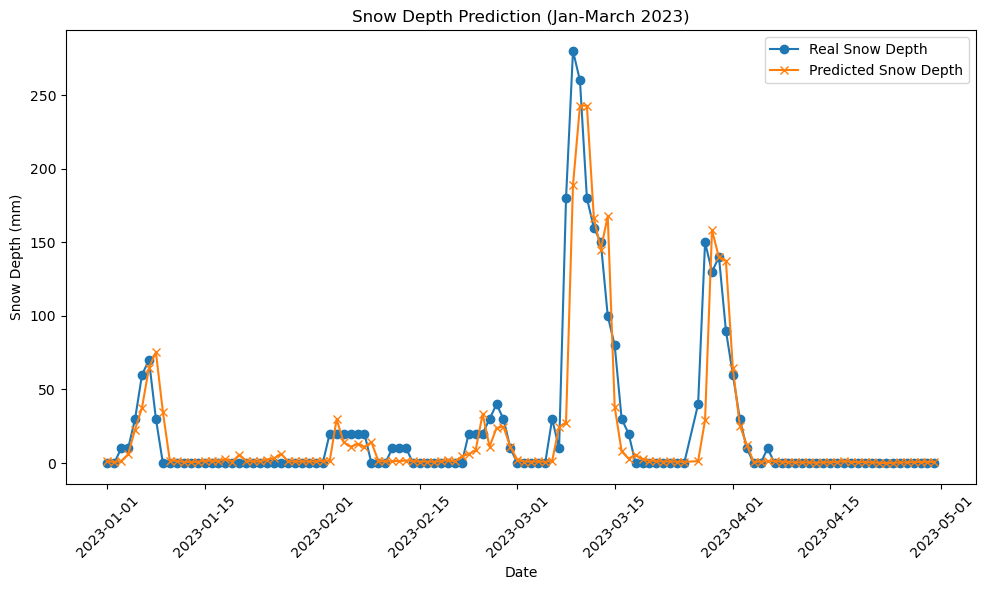

In [41]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# Extraire les données de janvier à mars 2023
test_data['y_pred'] = predictions
jan_mar_2023 = test_data[(test_data['date'] >= '2023-01-01') & (test_data['date'] <= '2023-04-30')]

# Plot des prédictions et des valeurs réelles de janvier à mars 2023
plt.figure(figsize=(10, 6))
plt.plot(jan_mar_2023['date'], jan_mar_2023['snow_depth_mm'], label='Real Snow Depth', marker='o')
plt.plot(jan_mar_2023['date'], jan_mar_2023['y_pred'], label='Predicted Snow Depth', marker='x')
plt.title('Snow Depth Prediction (Jan-March 2023)')
plt.xlabel('Date')
plt.ylabel('Snow Depth (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
0.5*mean_squared_error(jan_mar_2023['y_pred'], jan_mar_2023['snow_depth_mm'])


292.95012772748544

In [43]:
mean_absolute_error(jan_mar_2023['y_pred'], jan_mar_2023['snow_depth_mm'])

9.979862291271948

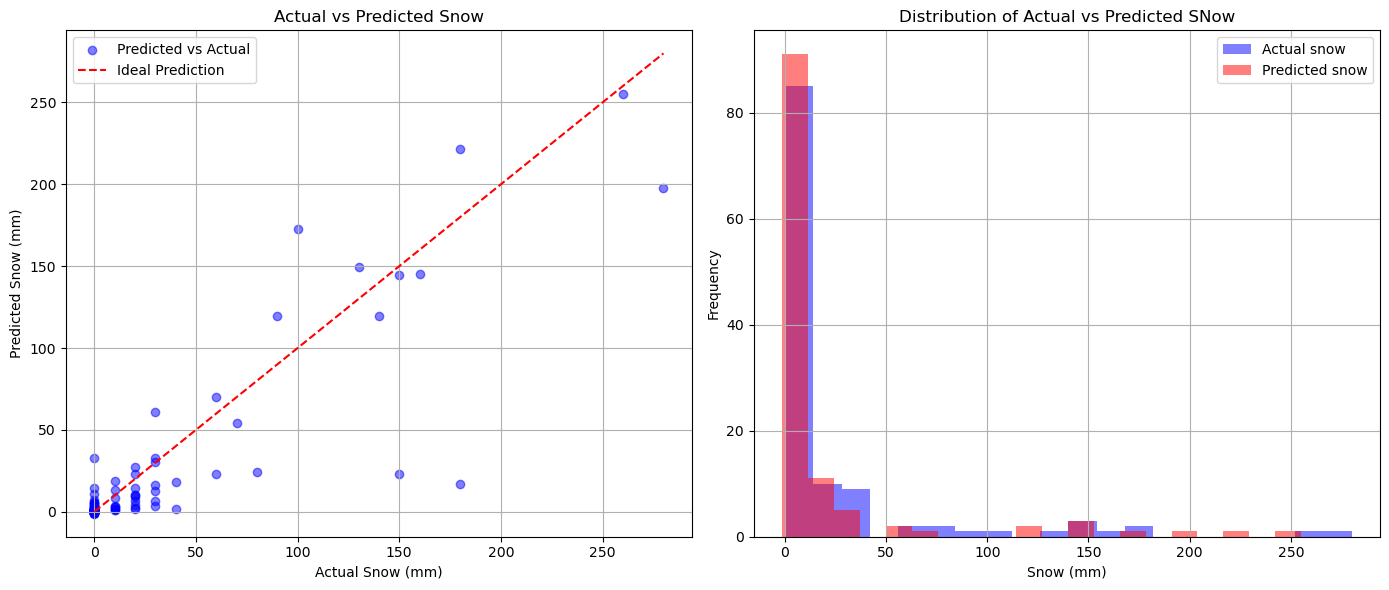

In [29]:
# Plotting Actual vs Predicted Temperature
plt.figure(figsize=(14, 6))

# Actual vs Predicted for Temperature
plt.subplot(1, 2, 1)
plt.scatter(jan_mar_2023['snow_depth_mm'], jan_mar_2023['y_pred'], color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([jan_mar_2023['snow_depth_mm'].min(), jan_mar_2023['snow_depth_mm'].max()], [jan_mar_2023['snow_depth_mm'].min(), jan_mar_2023['snow_depth_mm'].max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Snow')
plt.xlabel('Actual Snow (mm)')
plt.ylabel('Predicted Snow (mm)')
plt.legend()
plt.grid()

# Distribution of Actual and Predicted Temperatures
plt.subplot(1, 2, 2)
plt.hist(jan_mar_2023['snow_depth_mm'], bins=20, alpha=0.5, label='Actual snow', color='blue')
plt.hist(jan_mar_2023['y_pred'], bins=20, alpha=0.5, label='Predicted snow', color='red')
plt.title('Distribution of Actual vs Predicted SNow')
plt.xlabel('Snow (mm)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
